# Plotting data on a Smith chart

This notebook focuses on:

- Plotting points and sweeps (`ax.plot`, `ax.scatter`)
- Styling traces (markers, lines)
- Labels and legends
- Practical patterns for frequency sweeps
- Using `ax.annotate` and `ax.text`

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

import pysmithchart
from pysmithchart.constants import Z_DOMAIN, NORM_Z_DOMAIN, R_DOMAIN
from pysmithchart import utils

text_box = dict(facecolor="lightyellow")

## `ax.plot()` vs `ax.scatter()`

- `ax.plot(...)` is convenient for lines and markers, and integrates well with legends.
- `ax.scatter(...)` is convenient when you want point-specific sizes or colors.

In both cases, you can pass complex data directly.

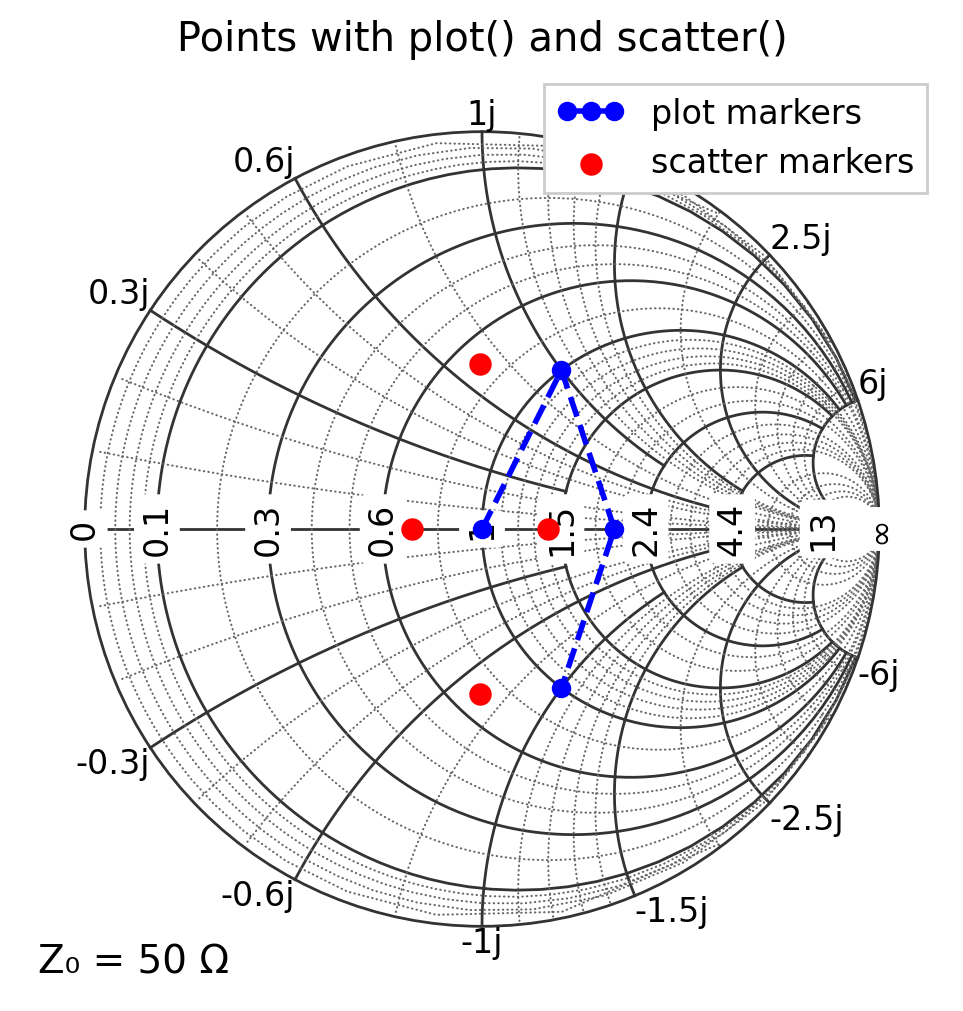

In [2]:
Z0 = 50  # default
Z = np.array([Z0 + 0j, Z0 + 1j * Z0, 2 * Z0 + 0j, Z0 - 1j * Z0])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot(Z, color="blue", marker="o", ms=6, ls="--", label="plot markers")
ax.scatter(Z * 0.7, s=50, c="r", label="scatter markers")

ax.legend(loc="upper right")
ax.set_title("Points with plot() and scatter()")
plt.show()

## What inputs does `plot()` accept?

Matplotlib (and `pysmithchart`) accept several common call patterns. All of the following are supported

### Complex array

```python
ax.plot(z_array)
ax.scatter(z_array)
```

Here `z_array` is a NumPy array of complex data points.

### Separate real and imaginary arrays

```python
ax.plot(x_array, y_array)
ax.scatter(x_array, y_array)
```

Here `x_array` and `y_array` are real-valued arrays (e.g., `x = np.real(Z)`, `y = np.imag(Z)`), and must be the same length.

### Single complex point vs single (x, y) point

```python
ax.plot(z)      # z is complex scalar
ax.plot(x, y)   # x and y are real scalars
```

For single points, remember that `plot()` only draws markers if a marker is specified (see next section).

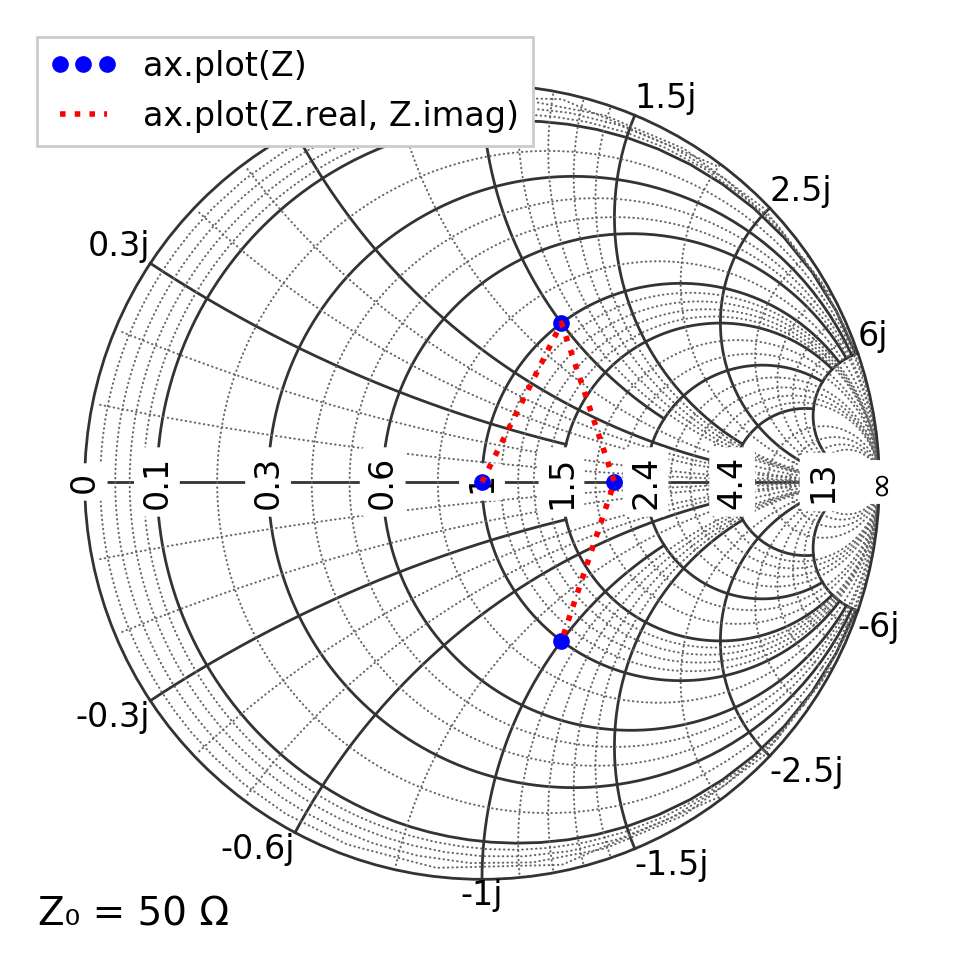

In [3]:
Z0 = 50  # default
Z = np.array([Z0 + 0j, Z0 + 1j * Z0, 2 * Z0 + 0j, Z0 - 1j * Z0])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot(Z, "bo", label="ax.plot(Z)")
ax.plot(Z.real, Z.imag, "r:", label="ax.plot(Z.real, Z.imag)")

ax.legend(loc="upper left")
plt.show()

## Points vs lines in `plot()` (format strings, markers, and line styles)

`ax.plot()` can draw **lines**, **markers**, or both. The behavior depends on the format string and/or keyword arguments:

- `'b'` draws a **blue line**. If you pass only a single point, there is no segment to draw, so you may see nothing.
- `'bo'` draws **blue circle markers** (and no line if you also use `linestyle=""`).
- `'b-'` draws a blue **solid line**.
- `'b--'` draws a blue **dashed line**.
- `'o'` draws circle markers (default color cycle).

Convenient style controls for `ax.plot()`:

- marker size: `ms=10` is the same as `markersize=10`
- line style: `ls="--"` is the same as `linestyle="--"`
- to draw markers only: `linestyle=""` (or `ls=""`)
- to draw line only: omit `marker` (or set `marker=""`) and keep a line style

The examples below illustrate a few common patterns.

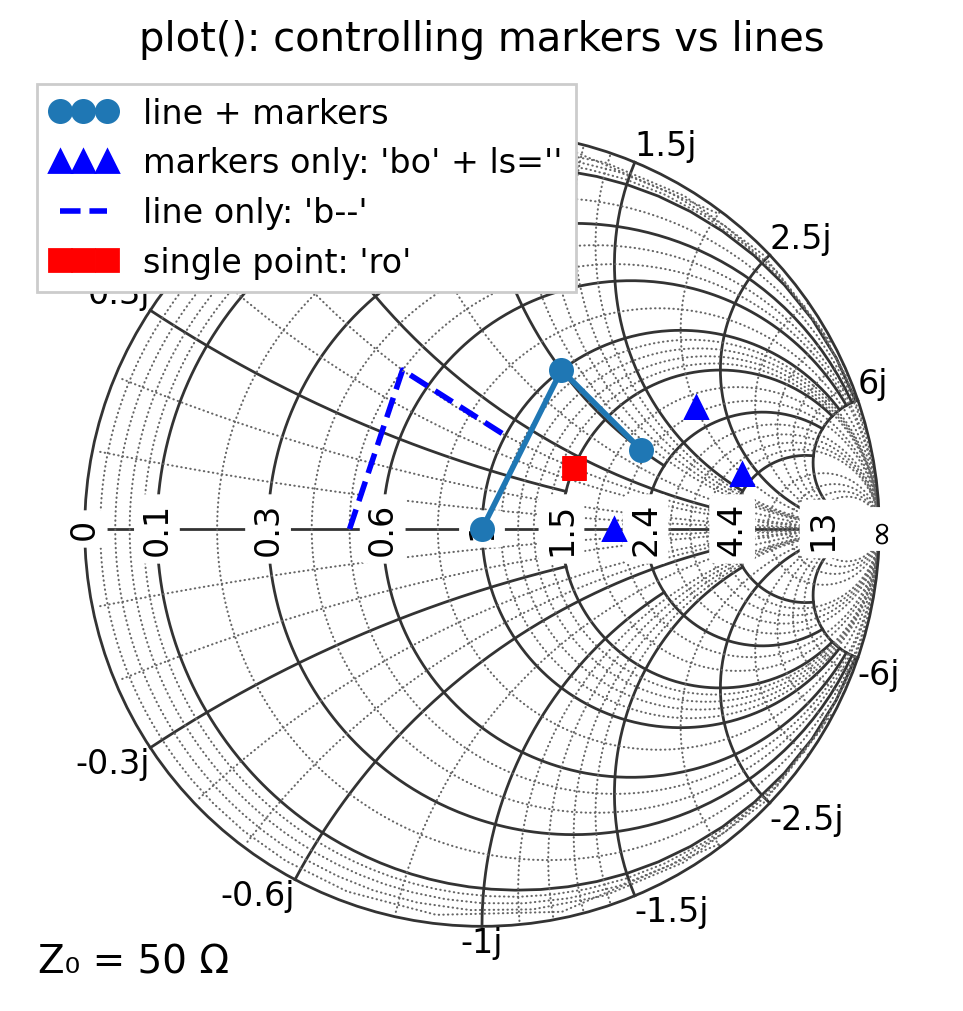

In [4]:
Z = np.array([50 + 0j, 50 + 1j * 50, 100 + 1j * 50])

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

# line + markers (explicit)
ax.plot(Z, marker="o", markersize=8, linestyle="-", label="line + markers")

# markers only (format string + ls="")
ax.plot(2 * Z, "b^", ls="", ms=8, label="markers only: 'bo' + ls=''")

# line only (no marker)
ax.plot(Z / 2, "b--", label="line only: 'b--'")

# single point: needs a marker to be visible
ax.plot(75 + 25j, "rs", ms=8, label="single point: 'ro'")

ax.legend(loc="upper left")
ax.set_title("plot(): controlling markers vs lines")
plt.show()

## Marker control with `ax.scatter()`

`ax.scatter()` is marker-based and does not draw connected line segments).
For some reason the controls differ from those `ax.plot()`:

- size is `s=...` (marker area in points²), not `markersize=...`
- marker shape is `marker="o"` (or `"s"`, `"^"`, etc.)
- you can set transparency with `alpha=...`


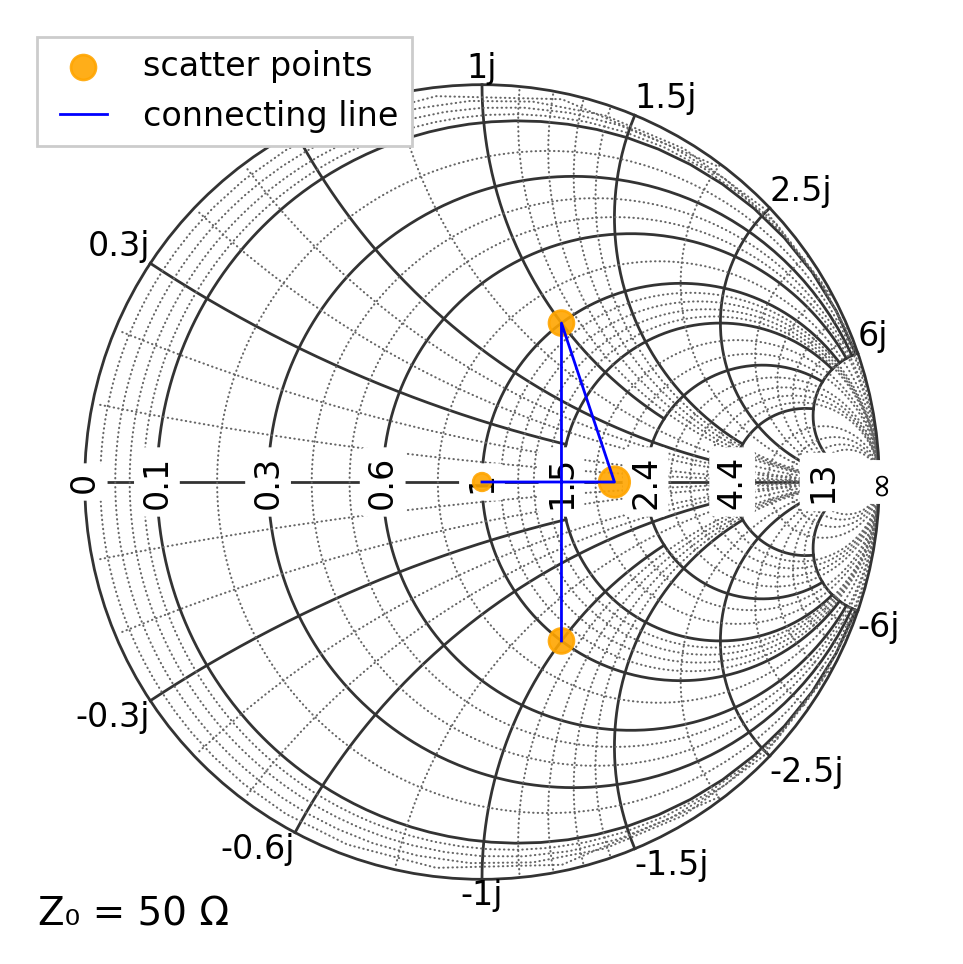

In [5]:
Z = np.array([50 + 0j, 100 + 0j, 50 + 1j * 50, 50 - 1j * 50])
sizes = [40, 120, 80, 80]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

# plot the points
ax.scatter(Z, c="orange", s=sizes, marker="o", alpha=0.9, label="scatter points")

# If you want a line through the same points, add plot() separately
ax.plot(Z, "b", lw=1, label="connecting line")

ax.legend(loc="upper left")
plt.show()

## Traces: plotting a sweep

A very common workflow is a **frequency sweep**, where the impedance changes with frequency.
A series RLC circuit has the following impedance

$$ 
Z(\omega) = R + j\left(\omega L - \frac{1}{\omega C}\right) 
$$

where $\omega=2\pi f$

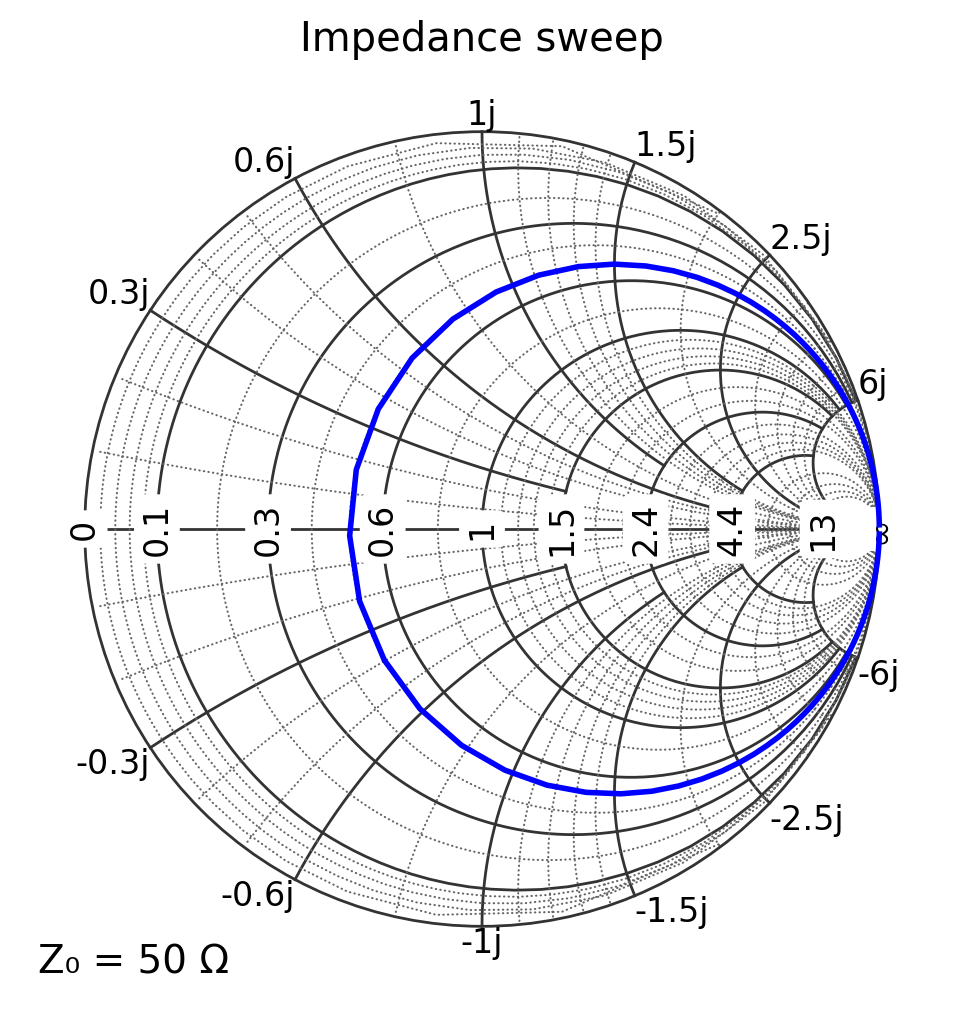

In [6]:
# Series RLC example impedance sweep
R = 25.0  # ohms
L = 150e-9  # H
C = 2.0e-12  # F

f = np.logspace(7, 10, 401)  # 10 MHz to 10 GHz
omega = 2 * np.pi * f
Z = R + 1j * (omega * L - 1 / (omega * C))

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")
ax.plot(Z, "b")
ax.set_title("Impedance sweep")
plt.show()

## `ax.text()` vs `ax.annotate()`

- `ax.text(x, y, "label")` places text at a location (no arrow).
- `ax.annotate("label", xy=(...), xytext=(...), arrowprops=...)` is best when you want to clearly point to a feature.

Both methods use the same domain rules as plotting. If you ever need to be explicit, pass `domain=...` to the call.

### Placing text independent of the Smith-chart domain

Sometimes you want text or annotations that are anchored to the chart frame, not to impedance, Γ, or any other domain quantity.
In that case, use Matplotlib's axes coordinate system:

```python
ax.text(0.05, 0.95, "Annotation text", transform=ax.transAxes)
```

where (0,0) is in the bottom left corner and (1,1) is in the top right.  This works regardless of the active Smith-chart domain.

### Labeling key frequencies

A readable chart usually labels just a few key points (start/middle/end or resonance).
Here we annotate the first, middle, and last frequency points.

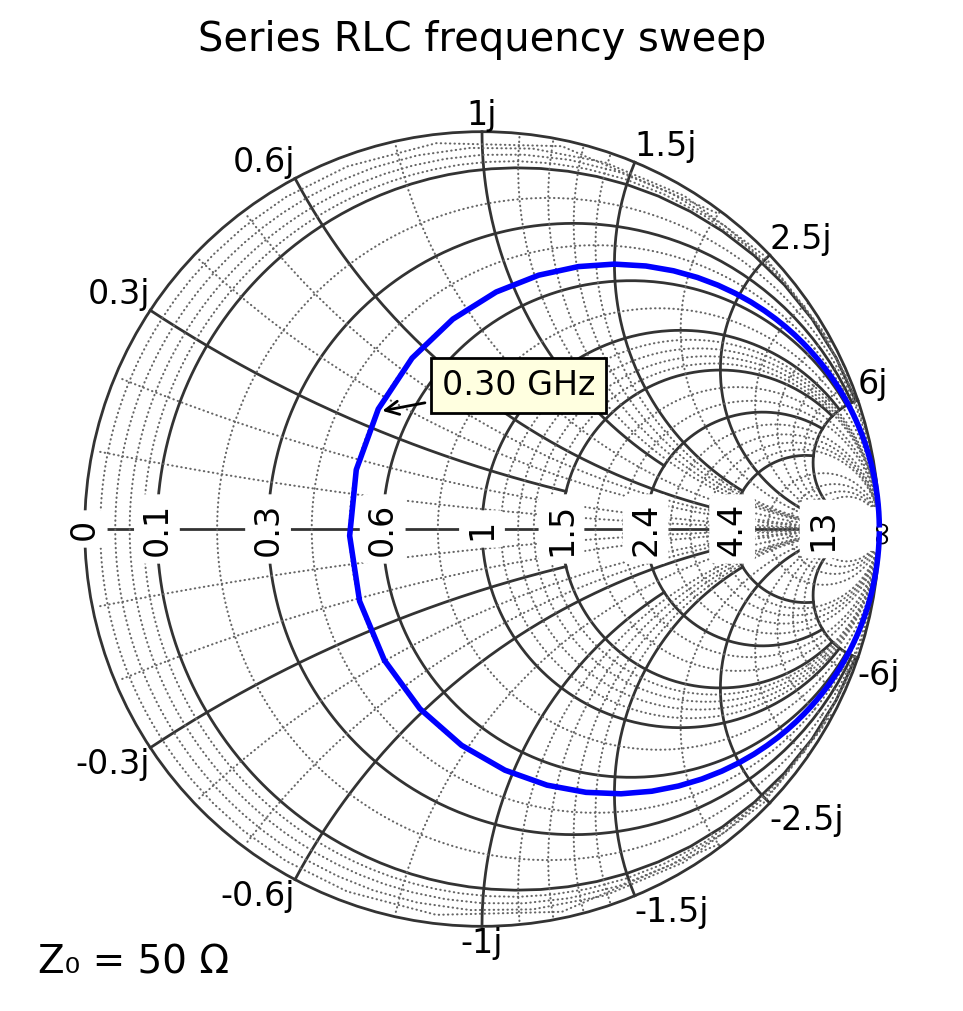

In [7]:
def Z_rlc(f):
    R = 25.0  # ohms
    L = 150e-9  # H
    C = 2.0e-12  # F
    omega = 2 * np.pi * f
    return R + 1j * (omega * L - 1 / (omega * C))


f = np.logspace(7, 10, 401)  # 10 MHz to 10 GHz

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot(Z_rlc(f), "b")

f = 3e8
Z = Z_rlc(f)
ax.annotate(
    f"{f/1e9:.2f} GHz",
    xy=(Z.real, Z.imag),
    xytext=(Z.real + 8, Z.imag + 8),
    arrowprops=dict(arrowstyle="->"),
    bbox=text_box,
)

ax.set_title("Series RLC frequency sweep")
plt.show()

## Plotting in Γ (reflection coefficient)

If your data source provides S11, S12, or Γ values, you can plot it directly using `R_DOMAIN`.

Reminder: in this domain, values must satisfy $|\Gamma| \leq 1$ to appear on the chart.

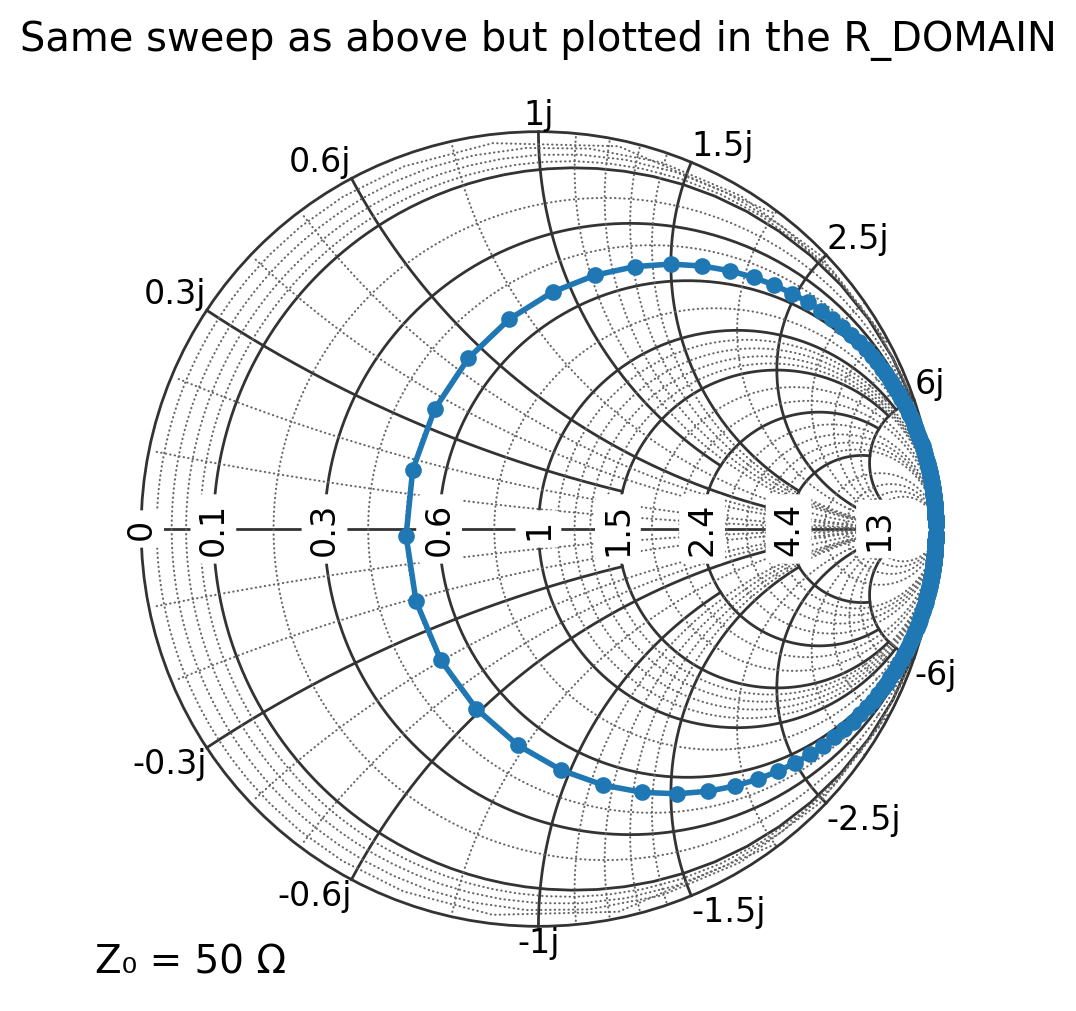

In [8]:
f = np.logspace(7, 10, 401)  # 10 MHz to 10 GHz
Gamma = utils.calc_gamma(Z0, Z_rlc(f))

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=R_DOMAIN)

ax.plot(Gamma)
ax.set_title("Same sweep as above but plotted in the R_DOMAIN")
plt.show()

## 5. Plotting with normalized impedance (NORM_Z_DOMAIN)

If you already normalized your data (e.g., in a homework problem), use `NORM_Z_DOMAIN` and pass \(z = Z/Z_0\).

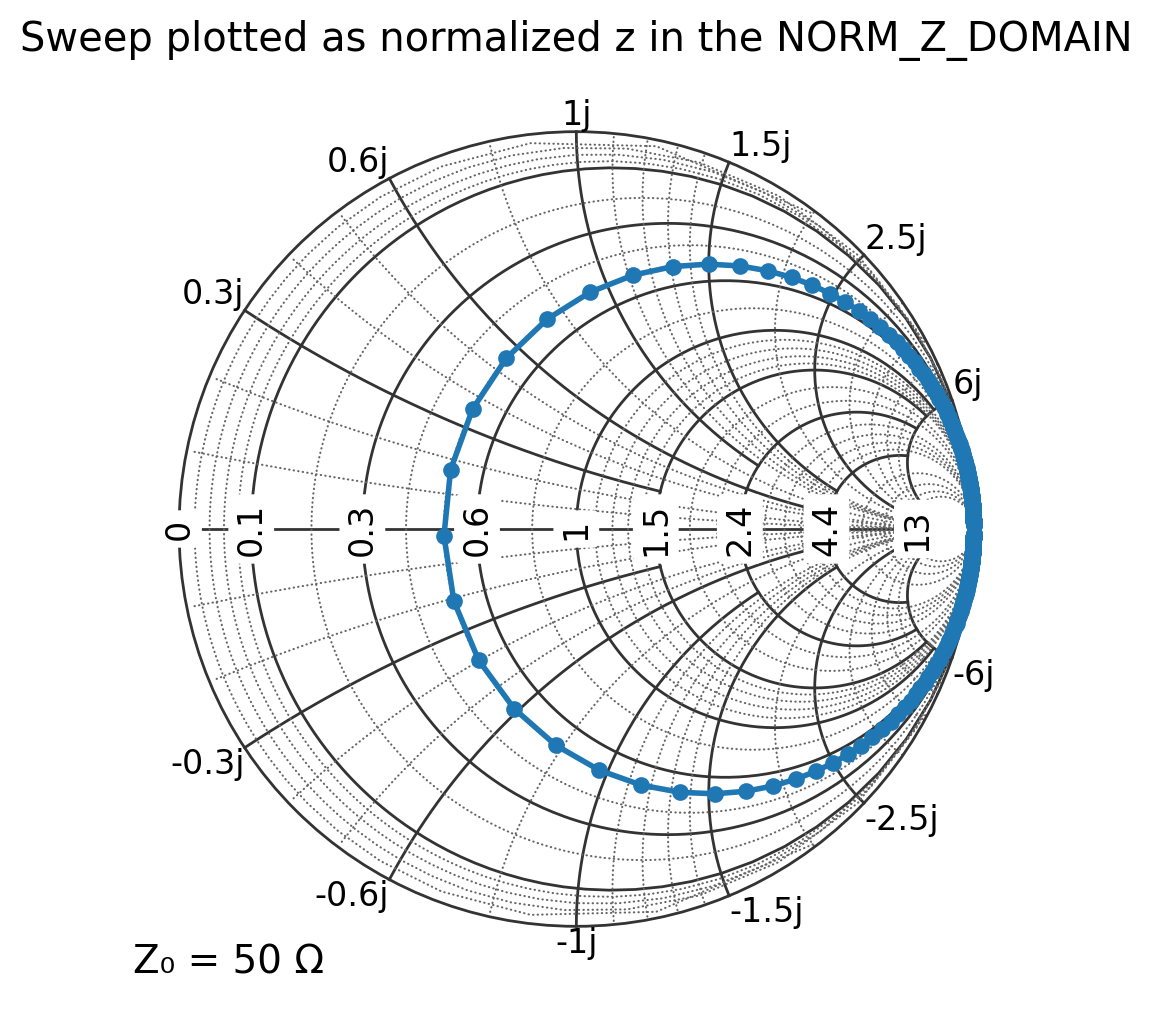

In [9]:
f = np.logspace(7, 10, 401)  # 10 MHz to 10 GHz
z = Z_rlc(f) / Z0

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", domain=NORM_Z_DOMAIN)

ax.plot(z, label="normalized z sweep")
ax.set_title("Sweep plotted as normalized z in the NORM_Z_DOMAIN")
plt.show()